<a href="https://colab.research.google.com/github/June103310110/Image_Segmentation/blob/main/PART1/03_Dilated_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dilated Convolution 空洞卷積
ref
https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md



In [ ]:
import gdown

gdown.download('https://drive.google.com/u/1/uc?id=10F2RJdLdOrxZt2sjJj748hpNU0Iz8hwU&export=download',
               'utils.py')

gdown.download('https://drive.google.com/u/1/uc?id=1TJ6Ya4oc7PwiLu6t5seZYdD6APMNKl-h&export=download',
               'capsule.zip')

!unzip -o capsule.zip -d ./data

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/u/1/uc?id=10F2RJdLdOrxZt2sjJj748hpNU0Iz8hwU&export=download 

Downloading...
From: https://drive.google.com/u/1/uc?id=1TJ6Ya4oc7PwiLu6t5seZYdD6APMNKl-h&export=download
To: /content/capsule.zip
100%|██████████| 11.7M/11.7M [00:00<00:00, 129MB/s]


Archive:  capsule.zip
  inflating: ./data/capsule/ground_truth/scratch/000_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/001_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/002_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/003_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/004_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/005_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/006_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/007_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/008_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/009_mask.png  
  inflating: ./data/capsule/test/scratch/000.png  
  inflating: ./data/capsule/test/scratch/001.png  
  inflating: ./data/capsule/test/scratch/002.png  
  inflating: ./data/capsule/test/scratch/003.png  
  inflating: ./data/capsule/test/scratch/004.png  
  inflating: ./data/capsule/test/scratch/005.png  
  inflating: ./data/capsule/test

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os   
import cv2
import numpy as np
import torch.optim as optim
from utils import show_image_mask

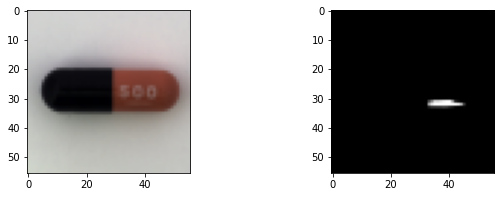

In [ ]:
i = '001'
image_ = cv2.imread(f'{os.getcwd()}/data/capsule/test/scratch/{i}.png')
image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)

mask_ = cv2.imread(f'{os.getcwd()}/data/capsule/ground_truth/scratch/{i}_mask.png', cv2.IMREAD_GRAYSCALE)

image_ = cv2.resize(image_, (56, 56), interpolation=cv2.INTER_AREA)
mask_ = cv2.resize(mask_, (56, 56), interpolation=cv2.INTER_AREA)
show_image_mask(image_, mask_)

torch.Size([1, 3, 56, 56])
torch.Size([1, 1, 56, 56])


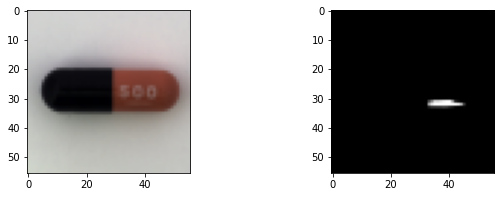

In [ ]:
image = torch.Tensor(image_).unsqueeze(0).permute(0,3,1,2)
mask = torch.Tensor(mask_)[...,None,None].permute(2,3,0,1)

print(image.shape)
print(mask.shape)
show_image_mask(image, mask)

### dilated conv. block layer 

In [ ]:
class dilated_conv(nn.Module):
    def __init__(self, in_ch, out_ch, dilated_rate, kernel_size=3, stride=1, padding='same'):
      super().__init__()
      self.dilated_rate= dilated_rate
        # 如果需要同時多重空洞卷積，可以對dilated_rate輸入list. e.g. [1,2,3]

      if padding=='same':
        padding = dilated_rate

      self.dilatedConv       = nn.Conv2d(in_ch, out_ch, kernel_size=3,
                              stride=stride, dilation=dilated_rate, padding=padding)
      self.relu           = nn.ReLU()
      self.INorm          = torch.nn.InstanceNorm2d(out_ch)

    def forward(self, x):
      tmp = x
      x = self.dilatedConv(x)
      if x.shape[2]==1 & x.shape[3]==1: #torch不能對1x1的feature-map做Batch-norm或Instance-norm
        pass  
      else:
        x = self.INorm(x)
      x = self.relu(x)

      return x

In [ ]:
x = torch.randn(1, 3, 13, 13)
x = dilated_conv(3, 3, dilated_rate=2, padding=0)(x)
print(x.shape)

torch.Size([1, 3, 9, 9])


## deepLab method (空洞卷積, dilated conv.的進階應用)
> - SPP
> - ASPP

### SPP layer

In [ ]:
import math
import torch
import torch.nn.functional as F

class SPPLayer(torch.nn.Module):

  def __init__(self, num_levels, pool_type='max_pool'):
    super(SPPLayer, self).__init__()

    self.num_levels = num_levels
    self.pool_type = pool_type

  def forward(self, x):
    num, c, h, w = x.size() # num: 樣本數, c: 通道數, h: 影像的高(rows), w: 影像的寬(cols)
    out = torch.Tensor([])
    for i in range(self.num_levels):
      level = i+1
      kernel_size = (math.ceil(h / level), math.ceil(w / level))
      stride = (math.ceil(h / level), math.ceil(w / level))
      pooling = (math.floor((kernel_size[0]*level-h+1)/2), math.floor((kernel_size[1]*level-w+1)/2))

      # 选择池化方式 
      if self.pool_type == 'max_pool':
        tensor = F.max_pool2d(x, kernel_size=kernel_size, stride=stride, padding=pooling).view(num, -1)
      else:
        tensor = F.avg_pool2d(x, kernel_size=kernel_size, stride=stride, padding=pooling).view(num, -1)
          
      print(tensor.shape)
      out = torch.cat((out, tensor), 1)

      return out.flatten()

In [ ]:
x = torch.randn(1, 16, 13, 13)
x = SPPLayer(num_levels=3, pool_type='max_pool')(x)
print(x.shape)

torch.Size([1, 16])
torch.Size([16])


### ASPP AdaptiveAvg2D pooling

In [ ]:
from torch import nn
import torch
import torch.nn.functional as F

class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.aspp_pooling = nn.Sequential(
          nn.AdaptiveAvgPool2d(1),
          nn.Conv2d(in_channels, out_channels, 1, bias=False))
      self.BatchNorm2d = nn.BatchNorm2d(out_channels)
      self.relu = nn.ReLU()

      
    def forward(self, x):
      size = x.shape[-2:]
      x = self.aspp_pooling(x)
      if x.shape[0]>1:
        x = self.BatchNorm2d(x)
      x = self.relu(x)
      return F.interpolate(x, size=size, mode='bilinear', align_corners=False)


In [ ]:
x = torch.randn(1, 16, 56, 56)
x = ASPPPooling(16, 10)(x)
print(x.shape)

torch.Size([1, 10, 56, 56])


### ASPP layer

In [ ]:
class ASPP(nn.Module):
    def __init__(self, in_channels, dilated_rate):
        super(ASPP, self).__init__()
        out_channels = 256
        modules = []
        # 並行的5個小分支
        ## 1號: 1x1 conv
        modules.append(nn.Sequential( # 1x1 conv
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))
        ## 2,3,4號: 3個不同dilated rate的分支，padding=same
        dilated_rate = tuple(dilated_rate)
        modules += [dilated_conv(in_channels, out_channels, i) for i in dilated_rate] # dilated conv with instance norm.
        ## 5號: ASPP pooling
        modules.append(ASPPPooling(in_channels, out_channels)) # ASPP pooling

        # 把5個小分支合併在一起
        self.convs = nn.ModuleList(modules)

        # ASPP層的輸出，做了一些norm.和dropout
        self.project = nn.Sequential(
            nn.Conv2d(5 * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)
aspp = ASPP(256,[6,12,18])
x = torch.rand(2,256,13,13)
print(aspp(x).shape)


torch.Size([2, 256, 13, 13])


## 補充: 空洞卷積另一個方向的改進 HDC method
> Panqu Wang,Pengfei Chen, et al.Understanding Convolution for Semantic Segmentation.//WACV 2018
![](https://i.imgur.com/dWbQgOv.png)

空洞卷積可以擴大感受野，這也是pooling的目的之一(感受野、參數量)。
- 兩個3x3的卷積可以獲得5x5的感受野，但兩個3x3，dilated-rate=2的空洞卷積可以獲得13x13的感受野。
- 缺點如下圖(a)，當使用連續使用3層dilated-rate=2的空洞卷積，空洞的操作會讓原始影像的部分資訊永遠缺失。
- 改良方法包括HDC，混合式的空洞卷積，透過鋸齒狀的dilated-rate設計(e.g. [1,2,3]，最大公因數為1的組合)，可以在擴大感受野的同時將原始影像資訊保留。
  - 嚴謹公式如下: $$M_i=max[M_i+1−2r_i, M_i+1−2(M_i+1−r_i), r_i]$$
  - 3個連續卷積中的第2個表示為: $$M_2$$
  - kernel_size表示為: $$K*K$$
  - 第i層卷積的dilated rate表示為 $$r_i$$
  - 目標是$$M_2 <= K$$



In [ ]:
K = 3
rate = [1,2,3]
def valid_HDC(K, rate):
  M2 = rate[1]
  M3 = rate[2]
  r2 = M2
  M2 = max([M3+1-2*r2, M3+1-2*(M3-r2), r2])
  assert M2<= K,'HDC not valid'

valid_HDC(3, [1,3,4])